In [1]:
# from pathlib import Path
# import shutil
# import pandas as pd

# use labels to separate files into folders

# data = pd.read_csv('cnn_homework/train_labels.csv')

# train_path = Path('cnn_homework/train_data/train')
# path_pos = Path('cnn_homework/train_data/positive')
# path_neg = Path('cnn_homework/train_data/negative')

# path_pos.mkdir(exist_ok=True, parents=True)
# path_neg.mkdir(exist_ok=True, parents=True)

# for label, df in data.groupby('label'):
#   for row in df.itertuples(name='Row', index=False):
#     img_path = train_path / row.img_name
#     dest_path = path_pos / row.img_name if label == 1 \
#       else path_neg / row.img_name

#     shutil.move(img_path, dest_path)



# ! rm -rf cnn_homework/train_data/train
# ! pip install torchdatasets

In [26]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchdatasets as td
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import pandas as pd

cudnn.benchmark = True
plt.ion()   # interactive mode

In [33]:
data_dir = 'cnn_homework/'

# defining transformations to the training data
train_transform =  transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_val_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'train_data'), train_transform)

train_val_size = len(train_val_dataset)
class_names = train_val_dataset.classes

# # discard 80% of the data just for testing stuff
# # remove this to use all the data
# discard = 8 * train_val_size // 10 # discard 80%
# train_val_size = train_val_size - discard # keep 20%

# # split randomly in 20 and 80% chunks
# train_val_dataset, _ = torch.utils.data.random_split(
#     train_val_dataset, (train_val_size, discard)
# )
# # end

#separate train data into train and validation 
train_count = 8 * train_val_size // 10
val_count = train_val_size - train_count

train_dataset, val_dataset = torch.utils.data.random_split(
    train_val_dataset, (train_count, val_count)
)

batch_size = 32
num_workers = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [34]:
class ResNetModel:
    def __init__(self, device) -> None:
        self.model = torchvision.models.resnet50(pretrained=True)

        # freeze the model 
        for param in self.model.parameters():
            param.requires_grad = False

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)        

        # move model to GPU
        self.model = self.model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()

        # Only parameters of final layer are being optimized
        
#         self.optimizer = optim.SGD(self.model.fc.parameters(), 
#                                    lr=0.1, momentum=0.9, weight_decay=1e-4)
        self.optimizer = optim.Adam(self.model.fc.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, 
                                    weight_decay=1e-4, amsgrad=False)


        # Decay LR by a factor of 0.5 every 5 epochs
        self.lr = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.5)

    def train_model(self, 
                    train_loader, val_loader, 
                    train_count, val_count,
                    num_epochs=5):
        since = time.time()

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # train phase
            self.model.train()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = self.criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    self.optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # advance learning rate
            self.lr.step()

            epoch_loss = running_loss / train_count
            epoch_acc = running_corrects.double() / train_count
            
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)

            print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            # validation phase
            self.model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in val_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # forward
                with torch.set_grad_enabled(False):
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = self.criterion(outputs, labels)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / val_count
            epoch_acc = running_corrects.double() / val_count
            
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)

            print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(self.model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        self.model.load_state_dict(best_model_wts)
        
        return self.model, train_loss, train_acc, val_loss, val_acc    

In [5]:
resnet_model = ResNetModel(device=device)

In [6]:
best_model, train_loss, train_acc, val_loss, val_acc = resnet_model.train_model(
    train_loader=train_loader, val_loader=val_loader,
    train_count=train_count, val_count=val_count,
    num_epochs=60
)

Epoch 0/59
----------
Train Loss: 4.8017 Acc: 0.7586
Validation Loss: 3.2131 Acc: 0.8317

Epoch 1/59
----------
Train Loss: 4.3487 Acc: 0.7804
Validation Loss: 6.4347 Acc: 0.6281

Epoch 2/59
----------
Train Loss: 4.5721 Acc: 0.7760
Validation Loss: 1.8130 Acc: 0.8172

Epoch 3/59
----------
Train Loss: 3.8594 Acc: 0.7804
Validation Loss: 10.9208 Acc: 0.6426

Epoch 4/59
----------
Train Loss: 5.7714 Acc: 0.7703
Validation Loss: 3.6290 Acc: 0.8345

Epoch 5/59
----------
Train Loss: 2.4267 Acc: 0.8060
Validation Loss: 12.2629 Acc: 0.6050

Epoch 6/59
----------
Train Loss: 2.2381 Acc: 0.8003
Validation Loss: 5.0516 Acc: 0.6279

Epoch 7/59
----------
Train Loss: 2.6699 Acc: 0.7895
Validation Loss: 1.8563 Acc: 0.8435

Epoch 8/59
----------
Train Loss: 2.6634 Acc: 0.7907
Validation Loss: 8.7407 Acc: 0.5372

Epoch 9/59
----------
Train Loss: 3.0402 Acc: 0.7921
Validation Loss: 2.4908 Acc: 0.7986

Epoch 10/59
----------
Train Loss: 1.5892 Acc: 0.8093
Validation Loss: 1.7350 Acc: 0.8410

Epoch 1

In [27]:
# save best_model
torch.save(best_model, './best_model_all_resnet.pytorch')

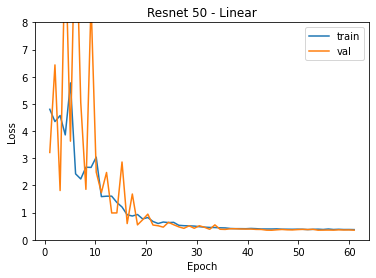

In [12]:
#PLOT TRAINING LOSS:
num_epoch = 60
train = np.array(train_loss)
val = np.array(val_loss)
epoch = np.linspace(1,num_epoch+1,num_epoch)
plt.plot(epoch, train, label = 'train')
plt.plot(epoch, val, label = 'val')
plt.ylim(0,8)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Resnet 50 - Linear")
plt.savefig('pytorch_resnet50_loss.png', dpi = 100)

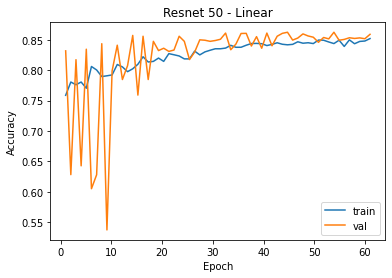

In [13]:
train_acc = np.array([e.item() for e in train_acc])
val_acc = np.array([e.item() for e in val_acc])

num_epoch = 60
epoch = np.linspace(1,num_epoch+1,num_epoch)
plt.plot(epoch, train_acc, label = 'train')
plt.plot(epoch, val_acc, label = 'val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Resnet 50 - Linear")
plt.savefig('pytorch_resnet50_accuracy.png', dpi = 100)

In [28]:
model = torch.load('best_model_all_resnet.pytorch')

In [30]:
directory = "./cnn_homework/test_data/test"
df = pd.DataFrame()   
ids = []
class0 = []
class1 = []
predictions = []

for filename in os.listdir(directory):
    image_id = filename
    ids.append(image_id)
    to_open =  "./cnn_homework/test_data/test/" + filename
    png = Image.open(to_open)

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),         
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_t = transform(png)
    batch_t = torch.unsqueeze(img_t, 0)
    
    model.eval()

    batch_t = batch_t.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(batch_t)
        _, preds = torch.max(outputs, 1)
    
    predictions.append(preds.item())
    percentage = torch.nn.functional.softmax(outputs, dim=1)[0]
    class0.append(percentage[0].tolist())
    class1.append(percentage[1].tolist())

df['img_name'] = ids
df['label'] = predictions 
# df['negative'] = class0
# df['positive'] = class1

In [31]:
df

,img_name,label
0,C136P97ThinF_IMG_20151005_144727_cell_108.png,1
1,C132P93ThinF_IMG_20151004_152808_cell_4.png,1
2,C145P106ThinF_IMG_20151016_154309_cell_112.png,0
3,C170P131ThinF_IMG_20151119_120233_cell_186.png,1
4,C170P131ThinF_IMG_20151119_120111_cell_25.png,0
...,...,...
5507,C168P129ThinF_IMG_20151118_153739_cell_15.png,0
5508,C113P74ThinF_IMG_20150930_134614_cell_173.png,1
5509,C208ThinF_IMG_20151029_155827_cell_146.png,0
5510,C132P93ThinF_IMG_20151004_152642_cell_35.png,1


In [32]:
df.to_csv('predictions_new.csv',index=False)